# News Headlines Sentiment

Use the news api to pull the latest news articles for stock and create a DataFrame of sentiment scores. 

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()


%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Read your api key environment variable
api_key = os.getenv("NEWS_API_KEY")

In [4]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [5]:
# Fetch the stock news articles; put in the ticker symbol of the stock you need information about
stock_headlines = newsapi.get_everything(q="TSLA", language="en", page_size=100,sort_by="relevancy")
stock_articles = stock_headlines["articles"]
stock_articles[0]

{'source': {'id': 'business-insider', 'name': 'Business Insider'},
 'author': 'Graham Rapier',
 'title': '2 more\xa0Tesla\xa0solar customers say the projects hurt their credit scores with unauthorized loans (TSLA)',
 'description': "Summary List PlacementTwo more customers of Tesla's home solar-energy system have filed a lawsuit claiming the company destroyed their credit by reporting loans they never asked for.\nYi Lee signed a deal with Solar City in 2014 to put solar panels on his Rowl…",
 'url': 'https://www.businessinsider.com/2-more-tesla-solar-customers-file-lawsuit-alleging-unauthorized-loans-2020-12',
 'urlToImage': 'https://i.insider.com/5fcfb574240ebd00126bdb26?width=1200&format=jpeg',
 'publishedAt': '2020-12-08T17:39:10Z',
 'content': "Two more customers of Tesla's home solar-energy system have filed a lawsuit claiming the company destroyed their credit by reporting loans they never asked for.\r\nYi Lee signed a deal with Solar City … [+2190 chars]"}

In [6]:
# Create the stock sentiment scores DataFrame
stock_sentiments = []

for article in stock_articles:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        stock_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
stock_df = pd.DataFrame(stock_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
stock_df = stock_df[cols]

In [7]:
# Drop duplicates articles
stock_df.drop_duplicates(keep="first", inplace=True)
stock_df.head()

,date,text,compound,positive,negative,neutral
0,2020-12-08,Two more customers of Tesla's home solar-energ...,-0.3612,0.069,0.135,0.796
1,2020-12-12,Although Tesla is currently the most valuable ...,0.5849,0.130,0.000,0.870
2,2020-12-19,Tesla's stock has been on an epic tear for all...,0.2960,0.059,0.000,0.941
3,2020-12-05,"Automobiles pollute, and with a climate crisis...",-0.9393,0.000,0.419,0.581
4,2020-12-25,In the annals of the electric-car and self-dri...,0.5106,0.093,0.000,0.907


In [8]:
# Describe the stock sentiment
stock_df.describe()

,compound,positive,negative,neutral
count,74.000000,74.000000,74.000000,74.000000
mean,0.201728,0.082514,0.039324,0.878135
std,0.424937,0.077239,0.069770,0.098037
min,-0.939300,0.000000,0.000000,0.581000
25%,0.000000,0.000000,0.000000,0.797250
50%,0.284600,0.069500,0.000000,0.897000
75%,0.542300,0.125500,0.060000,0.946250
max,0.904200,0.289000,0.419000,1.000000


---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each stock. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [9]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import regex
import re

In [10]:
stock_text_df = stock_df['text'].astype('string')
stock_text_df

0     Two more customers of Tesla's home solar-energ...
1     Although Tesla is currently the most valuable ...
2     Tesla's stock has been on an epic tear for all...
3     Automobiles pollute, and with a climate crisis...
4     In the annals of the electric-car and self-dri...
                            ...                        
82    After a true annus horribilus, were all ready ...
83    In a report on the alternative fuel market, an...
87    Apple's electric-vehicle project is surging ah...
88    Tesla CEO Elon Musk hasn't been shy about crit...
89    Elon Musk moved his charitable foundation to T...
Name: text, Length: 74, dtype: string

In [11]:
# Complete the tokenizer function
def tokenizer(text):

    """Tokenizes text."""

    # Create a list of the words
    words = [word_tokenize(sentence) for sentence in text]

    # Remove punctuation using regex; Remove any non-string character and replace with empty space
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words_clean = word_tokenize(re_clean)
   
   # Remove the stop words
    sw = set(stopwords.words('english'))
    first_pass = [word for word in words_clean if word not in sw]

    # Define additional stopwords
    sw_addon = {'char', 'chars' 'la', 'im','volod', 'drin', 'wa', 'ha'}
    second_pass = [word.lower() for word in words_clean if word.lower() not in sw.union(sw_addon)] 

    # Lemmatize Words into root words; convert the words to lowercase
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in words_clean]
    tokens = [word.lower() for word in lem if word.lower() not in sw.union(sw_addon)] 
  
    return tokens

In [12]:
# Tokenizing article in the first row of the "text" column
tokenizer(stock_text_df[0])

['two',
 'customer',
 'teslas',
 'home',
 'solarenergy',
 'system',
 'filed',
 'lawsuit',
 'claiming',
 'company',
 'destroyed',
 'credit',
 'reporting',
 'loan',
 'never',
 'asked',
 'foryi',
 'lee',
 'signed',
 'deal',
 'solar',
 'city']

In [13]:
# Create for-loop to iterate through rows in the "text" column 
stock_tokens = []
for row in stock_text_df:
    token = tokenizer(row)
    stock_tokens.append(token)

    print(stock_tokens) 

 'ever', 'reason', 'electric', 'vehicle', 'maker', 'potential', 'next', 'year', 'stock'], ['tesla', 'inc', 'ring', 'war', 'chest', 'around', 'billion', 'plenty', 'fund', 'ambitious', 'plan', 'include', 'launch', 'futuristiclooking', 'allelectric', 'pickup', 'heavyduty', 'truckstesla'], ['us', 'stockindex', 'future', 'tuesday', 'trading', 'lower', 'hospitalization', 'covid', 'hit', 'record', 'monday', 'progress', 'toward', 'another', 'coronavirus', 'aid', 'package', 'faltering', 'lawmaker', 'w'], ['december', 'teslas', 'tsla', 'long', 'wait', 'included', 'sampp', 'come', 'end', 'proven', 'capable', 'turning', 'profit', 'four', 'consecutive', 'quarter', 'minimum', 'requirement'], ['global', 'electricvehicle', 'sale', 'grow', 'next', 'year', 'sale', 'internal', 'combustion', 'engine', 'vehicle', 'expected', 'grow', 'thats', 'view', 'analyst', 'morgan', 'stanley'], ['chasm', 'havenots', 'combined', 'racial', 'discrimination', 'america', 'placed', 'greater', 'scrutiny', 'covid', 'pandemic',

In [14]:
# Create a new tokens column for the stock
stock_df['btc_token'] = stock_tokens
stock_df.head()

,date,text,compound,positive,negative,neutral,btc_token
0,2020-12-08,Two more customers of Tesla's home solar-energ...,-0.3612,0.069,0.135,0.796,"[two, customer, teslas, home, solarenergy, sys..."
1,2020-12-12,Although Tesla is currently the most valuable ...,0.5849,0.130,0.000,0.870,"[although, tesla, currently, valuable, automak..."
2,2020-12-19,Tesla's stock has been on an epic tear for all...,0.2960,0.059,0.000,0.941,"[teslas, stock, epic, tear, shares, completely..."
3,2020-12-05,"Automobiles pollute, and with a climate crisis...",-0.9393,0.000,0.419,0.581,"[automobiles, pollute, climate, crisis, loomin..."
4,2020-12-25,In the annals of the electric-car and self-dri...,0.5106,0.093,0.000,0.907,"[annals, electriccar, selfdrivingvehicle, era,..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each stock. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each stock. 

In [15]:
from collections import Counter
from nltk import ngrams

In [16]:
# Create one list of tokens from list of tokens in each row
stock_processed = []
for row in stock_df['btc_token']:
    for item in row:
        stock_processed.append(item)
        print(stock_processed)

er', 'reason', 'electric', 'vehicle', 'maker', 'potential', 'next', 'year', 'stock', 'tesla', 'inc', 'ring', 'war', 'chest', 'around', 'billion', 'plenty', 'fund', 'ambitious', 'plan', 'include', 'launch', 'futuristiclooking', 'allelectric', 'pickup', 'heavyduty', 'truckstesla', 'us', 'stockindex', 'future', 'tuesday', 'trading', 'lower', 'hospitalization', 'covid', 'hit', 'record', 'monday', 'progress', 'toward', 'another', 'coronavirus', 'aid', 'package', 'faltering', 'lawmaker', 'w', 'december', 'teslas', 'tsla', 'long', 'wait', 'included', 'sampp', 'come', 'end', 'proven', 'capable', 'turning', 'profit', 'four', 'consecutive', 'quarter', 'minimum', 'requirement', 'global', 'electricvehicle', 'sale', 'grow', 'next', 'year', 'sale', 'internal', 'combustion', 'engine', 'vehicle', 'expected', 'grow', 'thats', 'view', 'analyst', 'morgan', 'stanley', 'chasm', 'havenots', 'combined', 'racial', 'discrimination', 'america', 'placed', 'greater', 'scrutiny', 'covid', 'pandemic', 'raged', 'inf

In [17]:
# Generate the Bitcoin N-grams where N=2
stock_bigram = Counter(ngrams(stock_processed, n=2))
print(dict(stock_bigram))


n', 'stock'): 1, ('stock', 'price'): 1, ('price', 'electricvehicle'): 1, ('electricvehicle', 'manufacturer'): 1, ('manufacturer', 'chinese'): 1, ('chinese', 'ev'): 1, ('ev', 'company'): 1, ('company', 'nio'): 1, ('nio', 'inc'): 1, ('inc', 'nio'): 1, ('nio', 'annou'): 1, ('annou', 'mystery'): 1, ('mystery', 'company'): 1, ('company', 'leaving'): 1, ('leaving', 'sampp'): 1, ('index', 'make'): 1, ('make', 'room'): 1, ('room', 'silicon'): 1, ('silicon', 'valley'): 2, ('valley', 'juggernaut'): 1, ('juggernaut', 'tesla'): 1, ('inc', 'apartment'): 1, ('investment', 'management'): 1, ('management', 'cotesla'): 1, ('cotesla', 'tsla'): 1, ('tsla', 'set'): 1, ('set', 'joi'): 1, ('joi', 'reminded'): 1, ('reminded', 'u'): 1, ('u', 'much'): 1, ('much', 'late'): 1, ('late', 'thats'): 1, ('thats', 'chris'): 1, ('chris', 'harvey'): 1, ('harvey', 'head'): 1, ('head', 'equity'): 1, ('equity', 'strategy'): 2, ('strategy', 'wells'): 1, ('wells', 'fargo'): 1, ('fargo', 'securities'): 1, ('securities', 'wfc'

In [18]:
# Print 20 most common stock bigrams
print(dict(stock_bigram.most_common(20)))

{('tesla', 'inc'): 9, ('elon', 'musk'): 8, ('sampp', 'index'): 4, ('ceo', 'elon'): 4, ('tesla', 'tsla'): 4, ('tesla', 'share'): 4, ('joining', 'sampp'): 4, ('record', 'high'): 4, ('tesla', 'ceo'): 3, ('electric', 'car'): 3, ('share', 'exploded'): 3, ('exploded', 'gain'): 3, ('gain', 'nearly'): 3, ('nearly', 'year'): 3, ('year', 'gotten'): 3, ('gotten', 'recent'): 3, ('recent', 'boost'): 3, ('boost', 'joining'): 3, ('sampp', 'blockbuster'): 3, ('blockbuster', 'merely'): 3}


In [19]:
# Use the token_count function to generate the top 10 words from each stock
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [20]:
# Get the top 10 words for the stock
stock_top_ten = token_count(stock_processed)
stock_top_ten

[('tesla', 30),
 ('stock', 24),
 ('sampp', 16),
 ('market', 14),
 ('tsla', 12),
 ('year', 12),
 ('company', 10),
 ('one', 10),
 ('inc', 10),
 ('elon', 9)]

# Word Clouds

In this section, you will generate word clouds for the stock to summarize the news for each stock

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Word Cloud')

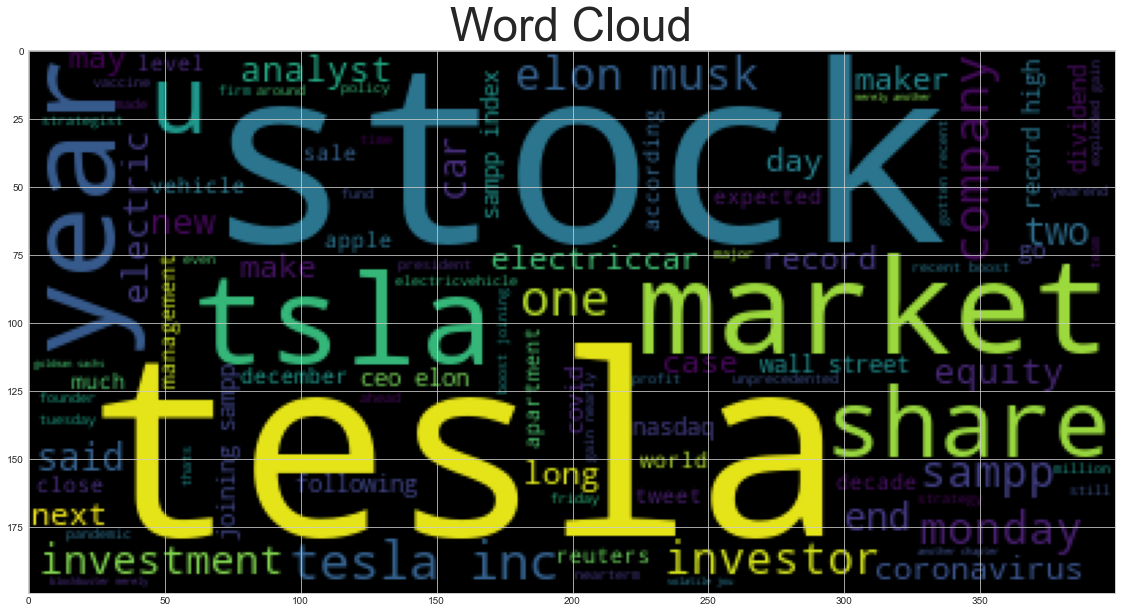

In [23]:
# Generate the stock word cloud
wc = WordCloud().generate(' '.join(stock_processed))
plt.imshow(wc)

# Add title to a Word Cloud 
plt.title("Word Cloud", fontdict={"fontsize":46})

# Named Entity Recognition

In this section, you will build a named entity recognition model for stock and visualize the tags using SpaCy.

In [24]:
import spacy
from spacy import displacy

In [25]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Stock NER

In [26]:
# Concatenate all of the stock text together
stock_joined = " ".join(stock_processed)

In [27]:
# Run the NER processor on all of the text
doc_stock = nlp(stock_joined)

# Add a title to the document
doc_stock.user_data["title"] = "Stock NER"

In [29]:
# Render the visualization
displacy.render(doc_stock, style='ent')

In [30]:
# List all Entities
print([ent.text for ent in doc_stock.ents])

['two', 'teslas home solarenergy', 'foryi lee', 'solar city', 'tesla', 'selfdrivingvehicle era', 'two decade ago', 'tesla', 'india', 'indian', 'monday day', 'tech carmaker', 'world second', 'n tesla', 'jeff bezos', 'two', 'december', 'one', 'tesla', 'muskmusk', 'reuters', 'sunday', 'tesla', 'twitter exchange', 'teslas stock', 'dow jones', 'tesla inc benchmark', 'reuters', 'end decade later', 'millionaire brandon smiths', 'de boutray', 'zevenbergen capital investments', 'yearthe zevenbergen genea fund de boutray comanages', 'yeartodate', 'nearly year', 'jou tesla', 'nearly year', 'jou', 'us', 'earlier year', 'one', 'nearly year', 'jou tesla inc stock', 'one', 'friday', 'fro donald trump', 'nobel', 'one', 'nikola corp', 'million', 'monday', 'earlier day', 'chris sacca', 'warning beginner', 'youin tweet', 'tuesday', 'one tiger', 'two', 'one', 'one', 'six percent', 'hour', 'fridays', 'afterhours million', 'chinese ev company nio inc nio', 'silicon valley juggernaut tesla inc apartment inve

---